<a href="https://colab.research.google.com/github/lblogan14/Python_Deep_Learning/blob/master/ch5_advanced_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning
Large datasets are not always available for the task being interested in. That's where the transfer learning comes in.

Transfer learning is the process of applying an existing trained ML model to a new, but related, problem.

Start with an existing pre-trained network. The most common scenario is to take anet pre-trained with ImageNet, but it could be any dataset.

Here CNN is used as the example to represent in this context. \\
Then, start with the network's features, which is the output of the last convolutional or pooling layer. Then, translate them to a different set of classes of the new task by means of removing the last fully-connected layer (or all fully-connected layers) of an existing pre-trained network and replacing it with another layer, which represents the classes of the new problem, as shown below.
![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch5/pre-trained_network.PNG?raw=true) 

Next, train the new layer wit data related to the new task. There are two options available:
* **Use the original part of the network as feature extractor and only train the new layer(s)**: feed the network a training batch of the new data and propagate it forward to see the network output. In the backward pass, lock the weight of the original network and only update the weights of the new layers. This works well if only limited training data are available. Locking most of the network weights prevents overfitting the new data.
* **Fine-tuning the whole network**: Train the whole network. Maybe lock some of the weights in the first layers or update all network weights. Because the initial layers detect general features - not related to a specific task. Deeper layers might detect task-specific features.

#Transfer learning with PyTorch
Apply an advanced ImageNet pre-trained network on the CIFAR-10 images. Use GPU to run the example.

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms

In [0]:
batch_size = 50

Define the training dataset:
* The CIFAR-10 images are 32x32, while the ImageNet network expects 224x224 input. Need to upsample the 32x32 CIFAR images to 224x224
* Add minor data augmentation (flip)
* Standardize the CIFAR-10 data using the ImageNet mean and standard deviation

In [0]:
# training data
train_data_transform = transforms.Compose([
      transforms.Resize(224),
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],
                           [0.229, 0.224, 0.225])
])

In [0]:
train_set = torchvision.datasets.CIFAR10(root='./data',
                                         train=True,
                                         download=True,
                                         transform=train_data_transform)

0it [00:00, ?it/s]

170500096it [00:06, 25671222.79it/s]                               


In [0]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)

Same steps for the validation/test data:

In [0]:
# validation data
val_data_transform = transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],
                           [0.229, 0.224, 0.225])
])

In [0]:
val_set = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=val_data_transform)

Files already downloaded and verified


In [0]:
val_order = torch.utils.data.DataLoader(val_set,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=2)

Choose a `device`, preferably GPU

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Define the training of the model. **PyTorch** requests users to iterate over the training data manually.

In [0]:
def train_model(model, loss_function, optimizer, data_loader):
  # set model to training mode
  model.train()

  current_loss = 0.0
  current_acc = 0

  # iterate over the training data
  for i, (inputs, labels) in enumerate(data_loader):
    # send the input/lables to the GPU
    inputs = inputs.to(device)
    labels = labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
      # forward
      outputs = model(inputs)
      _, predictions = torch.max(outputs, 1)
      loss = loss_function(outputs, labels)

      # backward
      loss.backward()
      optimizer.step()

    # statistics
    current_loss += loss.item() * inputs.size(0)
    current_acc += torch.sum(predictions == labels.data)

  total_loss = current_loss / len(data_loader.dataset)
  total_acc = current_acc.double() / len(data_loader.dataset)

  print('Train Loss: {:.4f}; Accuracy: {:.4f}'. format(total_loss, total_acc))

Define the testing/validation of the model. Similar steps but skipping the backpropagation 

In [0]:
def test_model(model, loss_function, data_loader):
  # set model in evaluation mode
  model.eval()

  current_loss = 0.0
  current_acc = 0

  # iterate over the validation data
  for i, (inputs, labels) in enumerate(data_loader):
    # send the input/labels to the GPU
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      _, predictions = torch.max(outputs, 1)
      loss = loss_function(outputs, labels)

    # statistics
    current_loss += loss.item() * inputs.size(0)
    current_acc += torch.sum(predictions == labels.data)

  total_loss = current_loss / len(data_loader.dataset)
  total_acc = current_acc.double() / len(data_loader.dataset)

  print('Test Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss, total_acc))

For the first transfer learning scenario, where the pre-trained network is used as a feature extractor:
* Use ResNet-18
* Replace the last network layer with a new laye with 10 outputs
* Exclude the existing network layers from the backward pass, and only pass the newly-added fully-connected layers to the Adam optimzier.

In [0]:
def tl_feature_extractor(epochs=3):
  # load the pre-trianed model
  model = torchvision.models.resnet18(pretrained=True)

  # exclude existing parameters from backward pass for performance
  for param in model.parameters():
    param.requires_grad = False

  # newly constrcuted layers have requires_grad=True by default
  num_features = model.fc.in_features
  model.fc = nn.Linear(num_features, 10)

  # transfer to GPU (if available)
  model = model.to(device)

  loss_function = nn.CrossEntropyLoss()

  # only parameters of the final layer are being optimized
  optimizer = optim.Adam(model.fc.parameters())

  # train
  for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))

    train_model(model, loss_function, optimizer, train_loader)
    test_model(model, loss_function, val_order)

For the second scenario, where the whole network is trained:

In [0]:
def tl_fine_tuning(epochs=3):
  # load the pre-trained model
  model = models.resnet18(pretrained=True)

  # replace the last layer
  num_features = model.fc.in_features
  model.fc = nn.Linear(num_features, 10)

  # transfer the model to the GPU
  model = model.to(device)

  # loss function
  loss_function = nn.CrossEntropyLoss()

  # fune-tuning: optimize all parameters
  optimizer = optim.Adam(model.parameters())

  # train
  for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1, epochs))

    train_model(model, loss_function, optimizer, train_loader)
    test_model(model, loss_function, val_order)

In [0]:
tl_feature_extractor(epochs=5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 76063663.83it/s]


Epoch 1/5
Train Loss: 1.0477; Accuracy: 0.6437
Test Loss: 0.7319; Accuracy: 0.7548
Epoch 2/5
Train Loss: 0.8603; Accuracy: 0.7002
Test Loss: 0.6870; Accuracy: 0.7621
Epoch 3/5
Train Loss: 0.8280; Accuracy: 0.7074
Test Loss: 0.6793; Accuracy: 0.7655
Epoch 4/5
Train Loss: 0.8220; Accuracy: 0.7118
Test Loss: 0.6827; Accuracy: 0.7637
Epoch 5/5
Train Loss: 0.8126; Accuracy: 0.7158
Test Loss: 0.6803; Accuracy: 0.7683


In [0]:
tl_fine_tuning(epochs=5)

Epoch 1/5
Train Loss: 0.7982; Accuracy: 0.7208
Test Loss: 0.6957; Accuracy: 0.7581
Epoch 2/5
Train Loss: 0.5258; Accuracy: 0.8178
Test Loss: 0.5505; Accuracy: 0.8098
Epoch 3/5
Train Loss: 0.4238; Accuracy: 0.8536
Test Loss: 0.4857; Accuracy: 0.8307
Epoch 4/5
Train Loss: 0.3635; Accuracy: 0.8759
Test Loss: 0.4076; Accuracy: 0.8636
Epoch 5/5
Train Loss: 0.3179; Accuracy: 0.8920
Test Loss: 0.4018; Accuracy: 0.8609


#Advanced Network Architectures

##VGG
The authors of the paper observed that a convolutional layer with a large filter size can be replaced with a stack of two or more convolutional layers with smaller filters (factorized convolution). For example, one 5x5 layer can be replaced with a stack of two 3x3 layers or a 7x7 layer with a stack of three 3x3 layers.

Advantages:
* The neurons of the last of the stacked layers have the equivalent receptive field size of a single layer with a large filter.
* The number of weights and operations of stacked layers is smaller, compared to a single layer with large filter size.
* Stacking multiple layers makes the decision function more discriminative.

The VGG networks consist of multiple blocks of two, three, or four stacked convolutional layers combined with a max-pooling layer. For example,
![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch5/vgg.PNG?raw=true)

As the depth of the VGG network increases, so does the width (number of filters) in the convolutional layers. Multiple pairs of convolutional layers are with a volume depth of 128/256/512 connected to other layers with the same depth. Also, there are two 4096-neuron fully-connected layers. Thus, the VGG networks have large number of parameters (weights), which makes them memory-inefficient, as well as computationally expensive.

###VGG models
For Keras,

To exclude the fully-connected layers, set `include_top` to `False`.

In [0]:
# VGG16
from keras.applications.vgg16 import VGG16

In [0]:
vgg16_model = VGG16(include_top=True,
                    weights='imagenet',
                    input_tensor=None,
                    input_shape=None,
                    pooling=None,
                    classes=1000)

In [0]:
# VGG19
from keras.applications.vgg19 import VGG19

In [0]:
vgg19_model = VGG19(include_top=True,
                    weights='imagenet',
                    input_tensor=None,
                    input_shape=None,
                    pooling=None,
                    classes=1000)

For PyTorch,

users can choose whether to use a pre-trained model

In [0]:
import torchvision.models as models

In [0]:
model = models.vgg16(pretrained=True)

##Residual Networks
The layers of a neural network are not restricted to sequential order, but form a graph instead. The residual network is the first network that takes advantage of this flexibility.

At the early experiment, the authors of the paper observed that a network with 56 layers had higher training and testing errors compared to a network with 20 layers. To solve this problem, they proposed a network constructed of residual blocks. A residual block consists of two or three sequential convolutional layers and a separate parallel identity (repeater) shortcut conneection, which connectes the input of the first layer and the output of the last one. There are three types of residual blocks:
![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch5/residual_blocks.PNG?raw=true)
From left to right, Original residual block, Original bottleneck block, Residual block v2.

Each block has two parallel paths. The left path is similar to the other networks we've seen, and consists of sequential convolutional layers + batch normalization. The right path contains the identity shortcut connection (also known as skip connection). The two paths are merged via an element-wise sum.

The features learned by the block are propagated forward but also with the original unmodified signal. The network can decide to skip some of the convolutional layers thanks to the skip connections, in effect reducing its own depth. The residual blocks use padding in such a way that the input and the output of the block have the same dimensions.

The following table lists related architectures proposed by the authors:
* They start with a 7x7 convolutional layer with stride 2, followed by 3x3 maxpooling.
* Downsampling is implemented with a modified residual block with stride 2.
* Average pooling downsamples the output after all residual blocks and before the fully-connected layer.

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch5/residual_networks.PNG?raw=true)

##Inception networks
A distant object might take up a small region of the image, but the same object, once nearer, might take up the majority of the image. This presents a
difficulty for standard CNNs, where the neurons in the different layers have a fixed receptive field size as imposed on the input image. A regular network might be a good detector of objects in a certain scale, but could miss them otherwise. 

This is where the inception blocks come into play. An inception block starts with a common input, and then splits it into different parallel paths (or towers). Each path contains either convolutional layers with a different-sized filter, or a pooling layer. 

###Inception v1
The first version of the inception block is shown up in the GoogleNet architecture as shown below:

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch5/inception_v1_block.PNG?raw=true)

The v1 block has four paths:
* 1x1 convolution, which acts as a kind of repeater to the input
* 1x1 convolution, followed by a 3x3 convolution
* 1x1 convolution, followed by a 5x5 convolution
* 3x3 maxpooling with a stride of 1

The layers in the block use padding in such a way that the input and the output have the same shape (but different depths).

The use of downsampling 1x1 convolutions is needed because the output of all paths is concatenated to produce the final output of the block. The result of the concatenation is an output with a quadrupled depth. If another inception blocks followed the current, its output depth would quadruple again. To avoid such exponential growth, the block uses 1 x 1 convolutions to reduce the depth for each path, which in turn reduces the output depth of the block. This makes it possible to create deeper networks, without running out of resources.

GoogleNet also utilizes auxiliary classifiers - that is, it has two additional classification output (with the same grouthtruth labels) at various intermediate layers. During training, the total value of the loss is a weighted sum of the auxiliary losses and the real loss.

###Inception v2 and v3
The first improvement of Inception v2 and v3 is the factorization of the 5x5 convolution in two stacked 3x3 convolutions, which is similar to the one shown in the VGG section as shown below:

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch5/inception_v2_block.PNG?raw=true)

The next improvement is the factorization of an `n x n` convolution in two stacked asymmetrical `1 x n` and `n x 1` convolutions. For example, a single 3x3 convolution can be splitted into two 1x3 and 3x1 convolutions, where the 3x1 convolution is applied over the output of the 1x3 convolution. In the 3x3 convolution, the filter size would be 3x3=9, while the latter factorization case, the filter size is combined with (3x1)+(1x3)=3+3=6, resulting in 33% efficiency.

Two new blocks were introduced here. The first is equivalent to the figure above and also shows below:

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch5/inception_v2_block_general.PNG?raw=true)

The second block is similar but the asymmetrical convolutions are parallel, resulting in a higher output depth (more concatenated paths):

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch5/inception_v2_block_general_2.PNG?raw=true)

###Inception v4 and Inception-ResNet
In the inception v4, the authors introduce three new streamlined inception blocks that build upon the idea of the previous versions. They inttroduce 7x7 asymmetric factorized convolutions, and average pooling instead of max pooling. In addition, they create a residual/inception hybrid network known as Inception-ResNet, where the inception blocks also include residual connections:
![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch5/Inception_skip_connection.PNG?raw=true)

###Xception and MobileNets
An output slice in standard convolution receives input from all input slices using a single filter. The filter tries to learn features in a 3D space, where two of the dimensions are spatial (the height and width of the slice) and the third is the channel. Therefore, the filter maps both spatial and cross-channel correlations.

The 1x1 convolution used in all inception blocks maps cross-channel correlations but not spatial ones (because of the 1x1 filter size). The author of Xception decoupled cross-channel and spatial correlations, so-called depthwise separable convolutions. A depthwise separable convolution combines two operations: a depthwise convolution and a 1x1 convoluton. In a depthwise convolution, a single input slice produces a single output slice, therefore it only maps spatial (and not cross-channel) correlations. With 1x1 convolutions, a single input slice maps the cross-channel correlations, as shown below:

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch5/depthwise_convolution.PNG?raw=true)

For example, if there are 32 input and output channels, and a filter with a size of 3x3. In a standard convolution, one output slice is the result of applying one filter for each of the 32 input slices for a total of 32x3x3=288 weights (excluding bias). In a comparable depthwise convolution, the filter has only 3x3=9 weights and the filter for the 1x1 convolution has 32x1x1=32 weights. The total number of weights is 32+9=41. Therefore, the depthwise separable convolution is both faster and more memory-efficient compared to the standard one.

The Xception network is built entirely of depthwise separable convolutions and it also includes residual connections.

MobileNets are another class of models, built with depthwise separable convolutions. These networks are lightweight and specifically optimized for mobile and embedded applications.

##DenseNets
DenseNet stands for **Densely-Connected Convolutional Networks**. It tries to alleviate the vanishing gradient problem and improve feature propagation, while reducing the number of network parameters. This is where the dense blocks come into play. A dense block consists of sequential convolutional layers, where any layer has a direct connection to all subsequent layers:

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch5/dense_block.PNG?raw=true)

* The different inputs are merged via concatenation, unlike ResNets, which use sum.
* A batch normalization and ReLU are applied over each concatenation, and then the result is fed to the following convolutional layer.
* A dense block is specified by its number of convolutional layers and the output volume depth of each layer, which is called **growth rate** in this context. Assume that the input of the dense block has a volume depth of $k_0$ and the output volume depth of each convolutional layer is $k$. Then, because of the concatenation, the input volume depth for the $l$-th layer will be $k_0+k\times(l-1)$. A second type of dense net, DenseNet-B, which applies a dimensionality-reduction 1x1 convolution after each concatenation.
* Although the later layers of a dense block have a large input volume depth, DenseNets can work with growth rate values as low as 12, which reduces the total number of parameters.
* To make concatenation possible, dense blocks use padding in such a way that the height and width of all output slices are the same throughout the block. The network uses average pooling between the dense blocks for downsampling.

#Capsule Networks

##Limitations of Convolutional Networks
CNNs are **translation-invariant**. Translation invariance means that a CNN is very good at telling the picture contains an object, but it cannot tell whether this object is in the left or right part of the image. The pooling layers should take the responsibility. By stacking multiple pooling layers, the receptive field size is gradually increased. But the detected object can be anywhere in the new receptive field, because none of the pooling layers relay such information. Therefore, the translation invariance is increased. Also, a CNN would be confused if the object had a different **orientation**.

In computer vision, the combination of translation and orientation is known as **pose**. The pose is enough to uniquely identify the object's properties in the coordinate system. The capsule networks preserve information for both the type and the pose of an object. Therefore, they can detect objects that can transform to each other, which is known as **equivariance**.

##Capsules
The output of a neuron is a scalar value. In contrast, the output of a **capsule** is a vector, which consists of the following:
* The elements of the vector represent the pose and other properties of the object.
* The length of the vector is in the (0,1) range and represents the probability of detecting the feature at that location. As a reminder, the length of a vector is $\|\vec{v}\|=\sqrt{\sum_{i=1}^{n}v_i^2}$, where $v_i$ are the vector elements.

Tge capsules are organized in interconnected layers, just such as a regular network. The capsules in one layer serve as input to the capsules in the next. Such as a CNN, the earlier layers detect basic features, and the deeper layers combine them in more abstract and complex ones. But now the capsules also relay positional information, instead of just detected objects. This allows the deeper capsules to analyze not only the presence of features, but also their relationship. The schematic of a capsule is shown below:

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch5/capsule.PNG?raw=true)

* The capsule inputs are the output vectors $u_1,u_2,...,u_n$, from the capsules of the previous layer.
* multiply each vector $u_i$, by its corresponding weight matrix, $W_{ij}$, to produce **prediction vectors**, $\hat{u_{j|i}}=W_{1j}u_i$. The weight matrices, $W$, encode spatial and other relationships between the lower-level features, coming from the capsules of the previous layer, and the high-level ones in the current layer. For example, if the capsule in the current layer detects faces and the capsules from the previous layer detect the mouth ($u_1$), eyes ($u_2$), and nose ($u_3$). Then, $\hat{u_{j|1}}=W_{1j}u_1$ is the predicted position of the face, given where the location of the mouth is. $\hat{u_{j|2}}=W_{2j}u_2$ predicts the location of the face based on the detected location of the eyes, and $\hat{u_{j|3}}=W_{3j}u_3$ predicts the location of the face based on the location of the nose. If all three lower-level capsule vectors agree on the same location, then the current capsule can be confident that a face is indeed present. The weights, $W$, are learned with backpropagation.
* multiply the $\hat{u_{i|j}}$ vectors by the scalar coupling coefficients, $c_{ij}$. These coefficients are a separate set of parameters, apart from the weight matrices. They exist between any two capsules and indicate which high-level capsules will receive input from a lower-level capsule. The coupling coefficients are computed on the fly during the forward pass via a process called **dynamic routing**.
* sum the weighted input vectors
$$\vec{s_j}=\sum_i c_{ij}\hat{u_{j|i}}$$
* compute the output of the capsule $v_j$, by squashing the vector $s_j$.

#Advanced Computer Vision Tasks

##Object Detection
Object detection is the process of finding object instances of a certain class, such as faces, cars, and trees, in images or videos. Object detection can detect multiple objects, as well as their location in the image.

An object detector returns a list of detected objects with the following information for each object:
* The class of the object (person, car, tree, and so on).
* Probability (or confidence score) in the [0,1] range, which conveys how confident the detector is that the object exists in that location
* The coordinates of the rectangular region of the image where the object is located. This rectangle is called a **bounding box**.

##Approaches to Object Detection
* **Classic sliding window**: Use a regular classification network (classifier). It's relatiely slow and error-prone:
  1. Build an image pyramid, a combination of different scales of the same image. Each scaled image can be two times smaller than the previous one so as to detect objects regardless of their size in the original image.
  2. Slide the classifier across the whole image. Use each location of the image as an input to the classifier and the result will determine what type of object is in that location. The bounding box of that location is just the image region that is used as input.
  3. There are multiple overlapping bounding boxes for each object. Use some heuristics to combine them in a single prediction.

* **Two-stage detection methods**: very accurate, but relatively slow.
  1. A special type of CNN, called a Region Proposal Network, scans the image and proposes a number of possible bounding boxes where objects might be lcoated. However, this network does not detect the type of the object, but only whether an object is present in the region.
  2. The regions of interest are sent to the second stage for object classification.

* **One-stage detection methods**: A single CNN produces both the object type and the bounding box. Faster, but less accurate compared to two-stage methods.

##Object Detection with YOLOv3
YOLO = "You only live once", reflects th one-stage nature of the algorithm.

* It works with a fully-convolutional network (without pooling layers) and usses residual connections and batch normalization. The YOLOv3 network uses three different scales of the image for prediction. What makes it different, though, is the use of special type of groundtruth/output data, which is a combination of classification and regression.
* The network takes the whole image as an input and outputs the bounding boxes, object classes, and confidence scores of all detected objects in just a single pass.

The YOLO works in the following processes:
1. Split the image, into a grid of $S\times S$ cells:
  * The network treats the center of each grid cell as the center of the region, where an object might be located.
  * An object might lie entirely within a cell. Then, its bounding box will be smaller than the cell. Alternatively, it can span over multiple cells and the bounding box will be larger. YOLO covers both cases.
  * YOLO can detect multiple objects in a grid cell with the help of **anchor
boxes**, but an object is associated with onc cell only (1-to-n relation). That is, if the bounding box of the object covers multiple cells, this object is associated with the cell, where the center of the bounding box lies.
  * Some of the cells may contain object and others might not.

2. The network output and target data is a one-stage classifier. Тhe network outputs possible detected objects for each grid cell. For example, if the grid is $3\times 3$, then the output will contain nine possible detected objects. The output data (and its corresponding label) for a single grid cell/detected object is an array with values, $[b_x, b_y, b_h, b_w, p_c, c_1, c_2,..., c_n]$, where:
  * $b_x,b_y,b_h,b_w$ describes the bounding box, (if an object exists). $b_x$ and $b_y$ are the coordinates of the upper-left coordinate of the box. They are normalized in the [0,1] range with respect to the size of the image. That is, if the image is of size 100x100 and $b_x=20$ and $b_y=50$, their normalized values would be 0.2 and 0.5. $b_h$ and $b_w$ represent the box height and width. They are normalized with respect to the grid cell. If the bounding box is larger than the cell, its value will be greater than 1. Predicting the box parameters is a regression task.
  * $p_c$ is a confidence score in the [0,1] range. The labels for the confidence score are either 0 (not present) or 1 (present), making this part of the output a classification task. If an object is not present, discard the rest of the array values.
  * $c_1,c_2,...,c_n$ is a one-hot encoding of the object class.

  The network output/labels will contain $S\times S$ such arrays.

3. In the case where multiple objects in the same cell, YOLO proposes to have multiple candidate boxes with a slightly different shape for each cell. The proper anchor box for an object during training is selected with the help of Intersection over Union (IoU), which is the ratio between the area of the intersection of the object bounding box/anchor box, and the area of their union:

![](https://github.com/lblogan14/Python_Deep_Learning/blob/master/img/ch5/iou.PNG?raw=true)

Compare the bounding box of each object to all anchor boxes, and assign the object to the anchor box with the highest IoU.

4. In the case of predictions, the noise in the output of the network can be got rid of using **non-maximum suppression**:
  1. Discard all bounding boxes with a confidence score <= 0.6
  2. From the remaining bounding boxes, pick the one with the hightest possible ocnfidence score.
  3. Discard any box whose IoU >= 0.5 with the box selected in the previous step.

##YOLOv3 with OpenCV


In [0]:
import os.path
import cv2
import numpy as np
import requests

In [0]:
# Download YOLO net config file from the YOLO author's github repo
yolo_config = 'yolov3.cfg'
if not os.path.isfile(yolo_config):
  url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg'
  r = requests.get(url)
  with open(yolo_config, 'wb') as f:
    f.write(r.content)

In [0]:
# Download YOLO net weights from the YOLO author's website
yolo_weights = 'yolov3.weights'
if not os.path.isfile(yolo_weights):
  url = 'https://pjreddie.com/media/files/yolov3.weights'
  r = requests.get(url)
  with open(yolo_weights, 'wb') as f:
    f.write(r.content)

In [0]:
# Download class names file
# contains the names of the classes the network can detect
classes_file = 'coco.names'
if not os.path.isfile(classes_file):
  url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names'
  r = requests.get(url)
  with open(classes_file, 'wb') as f:
    f.write(r.content)

In [0]:
# Load class names
with open(classes_file, 'r') as f:
  classes = [line.strip() for line in f.readlines()]

In [0]:
# Download object
image_file = 'source.jpg'
if not os.path.isfile(image_file):
  url = "https://upload.wikimedia.org/wikipedia/commons/c/c7/Abbey_Road_Zebra_crossing_2004-01.jpg"
  r = requests.get(url)
  with open(image_file, 'wb') as f:
    f.write(r.content)

In [0]:
# Read and Normalize image
image = cv2.imread(image_file)
blob = cv2.dnn.blobFromImage(image, 
                             1/255, 
                             (416,416), 
                             (0,0,0), 
                             True,
                             crop=False)

In [0]:
# Load the network
net = cv2.dnn.readNet(yolo_weights, yolo_config)

In [0]:
# Set as input to the net
net.setInput(blob)

In [0]:
# Get the network output layers
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [0]:
# Inference
# The network outputs multiple lists of anchor boxes,
# one for each detected class
outs = net.forward(output_layers)

In [0]:
# Extract bounding boxes
class_ids = list()
confidences = list()
boxes = list()

In [0]:
# Iterate over all classes
for out in outs:
  # iterate over the anchor boxes for each class
  for detection in out:
    # bounding box
    center_x = int(detection[0] * image.shape[1])
    center_y = int(detection[1] * image.shape[0])
    w = int(detection[2] * image.shape[1])
    h = int(detection[3] * image.shape[0])
    x = center_x - w // 2
    y = center_y - h // 2
    boxes.append([x,y,w,h])

    # class
    class_id = np.argmax(detection[5:])
    class_ids.append(class_id)

    # confidence
    confidence = detection[4]
    confidences.append(float(confidence))

In [0]:
# Non-max suppression
ids = cv2.dnn.NMSBoxes(boxes, 
                       confidences, 
                       score_threshold=0.3,
                       nms_threshold=0.5)

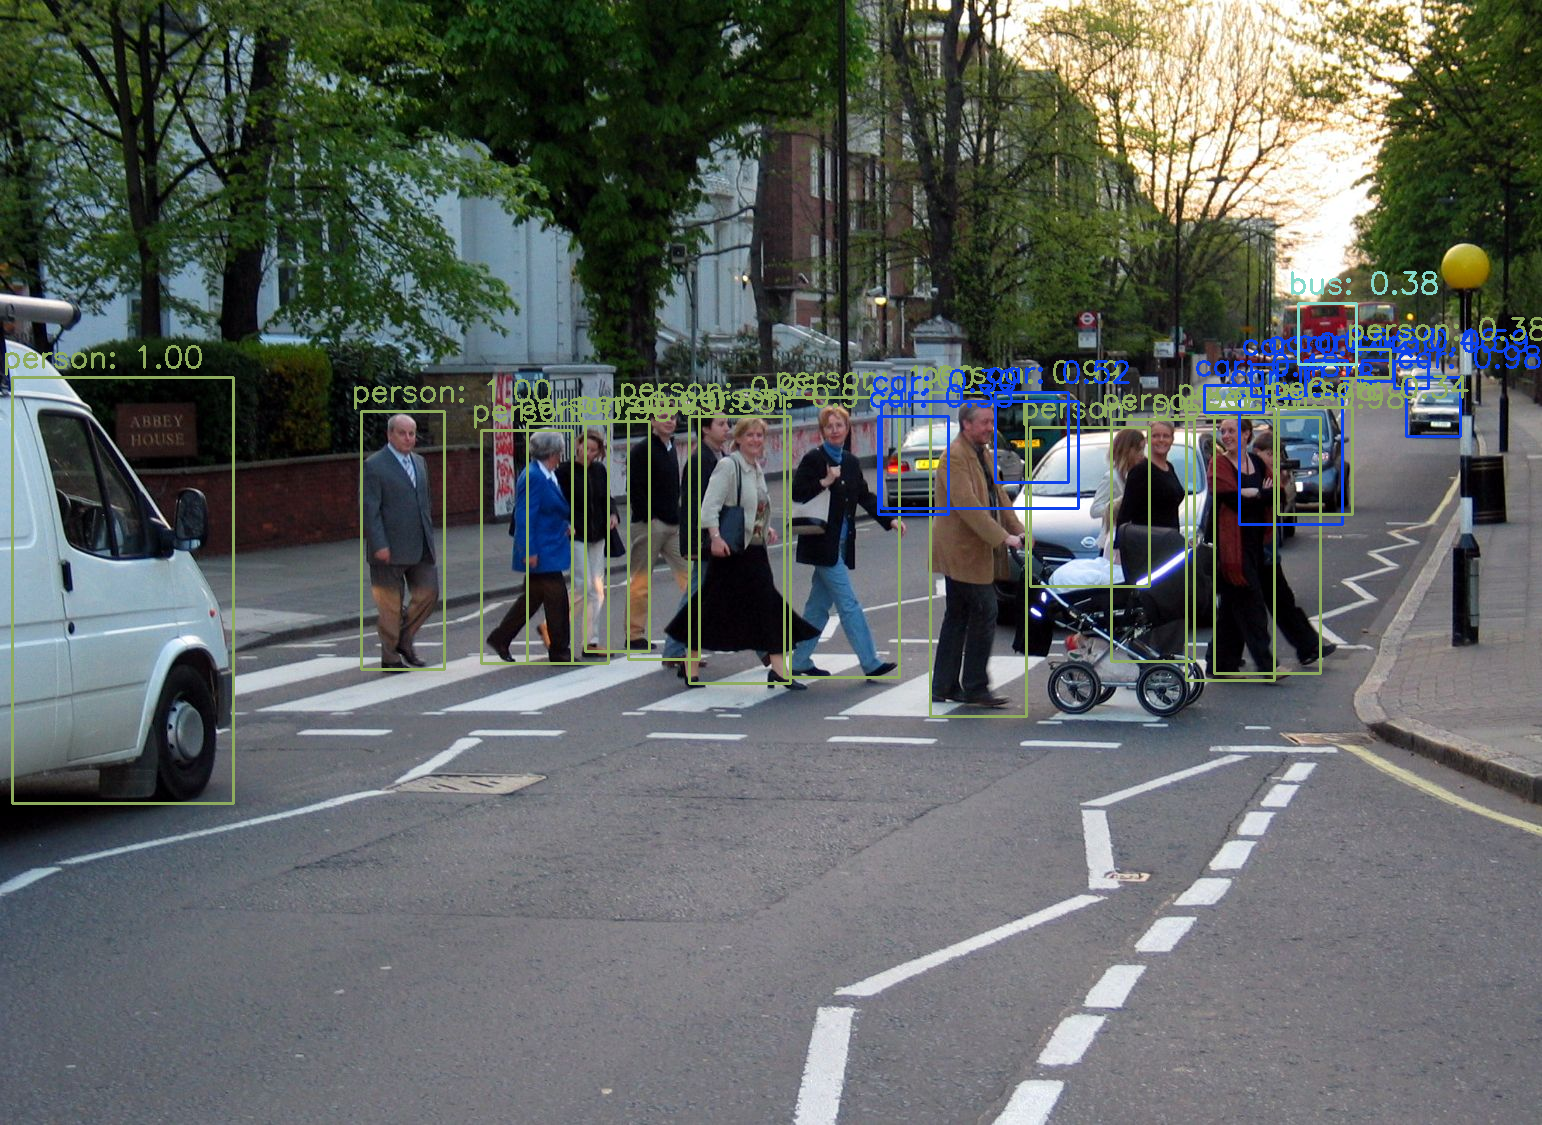

-1

In [19]:
from google.colab.patches import cv2_imshow

# Draw the bounding boxes on the image
colors = np.random.uniform(0, 255, size=(len(classes), 3))

for i in ids:
  i = i[0]
  x,y,w,h = boxes[i]
  class_id = class_ids[i]

  color = colors[class_id]

  cv2.rectangle(image,
                (round(x), round(y)),
                (round(x+w), round(y+h)),
                color,
                2)
  
  label = '%s: %.2f' % (classes[class_id], confidences[i])
  cv2.putText(image,
              label,
              (x-10, y-10),
              cv2.FONT_HERSHEY_SIMPLEX,
              1,
              color,
              2)
  
cv2_imshow(image)
cv2.waitKey()